In [1]:
%reset -f
%matplotlib inline

In [2]:
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import sebaba.ml as sbbml
import sebaba.utils as utils
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from scipy.stats import norm
from missingpy import KNNImputer

In [3]:
pd.options.display.float_format = "{:.4f}".format

In [4]:
train_df = pd.read_csv("data/house-prices/train.csv", sep = ",")
train_df = train_df.drop("Id", axis = 1)
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
utils.missing_var_pct(train_df)

PoolQC         99.5200
MiscFeature    96.3000
Alley          93.7700
Fence          80.7500
FireplaceQu    47.2600
LotFrontage    17.7400
GarageType      5.5500
GarageCond      5.5500
GarageFinish    5.5500
GarageQual      5.5500
GarageYrBlt     5.5500
BsmtFinType2    2.6000
BsmtExposure    2.6000
BsmtQual        2.5300
BsmtCond        2.5300
BsmtFinType1    2.5300
MasVnrArea      0.5500
MasVnrType      0.5500
Electrical      0.0700
dtype: float64


In [6]:
def clean_df(df = None):
    df = utils.drop_missing_var(df, threshold = 0.8)
    df = df.drop("GarageYrBlt", axis = 1)

    basement       = ["BsmtFinType2", "BsmtExposure", "BsmtFinType1", "BsmtCond", "BsmtQual"]
    df[basement]   = df[basement].fillna("NoBasement")
    garage         = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]
    df[garage]     = df[garage].fillna("NoGarage")
    df.FireplaceQu = df.FireplaceQu.fillna("NoFirePlace")

    imputer        = KNNImputer(n_neighbors = 5, weights = "distance", metric = "masked_euclidean")
    df.LotFrontage = imputer.fit_transform(np.array(df.LotFrontage).reshape(-1, 1))

    #changing numeric variables to categorical
    df.MSSubClass = ["SC" + str(i) for i in df.MSSubClass]
    df.MoSold     = [calendar.month_abbr[i] for i in df.MoSold]

    #converting cat variables to an interval scale as they are ordinal in nature
    df = df.replace({
        "GarageFinish": {"NoGarage": 0, "Unf": 1, "RFn": 2, "Fin": 3},
        "GarageQual"  : {"NoGarage": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "GarageCond"  : {"NoGarage": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "BsmtQual"    : {"NoBasement": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "BsmtCond"    : {"NoBasement": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "BsmtExposure": {"NoBasement": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4},
        "BsmtFinType1": {"NoBasement": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6},
        "BsmtFinType2": {"NoBasement": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6},
        "ExterQual"   : {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterCond"   : {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "HeatingQC"   : {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "KitchenQual" : {"Po": 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
        "FireplaceQu" : {"NoFirePlace": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex" : 5}
    })

    #changing features to their correct data types
    df.BsmtCond     = df.BsmtCond.astype("int64")
    df.BsmtFinType2 = df.BsmtFinType2.astype("int64")
    df.FireplaceQu  = df.FireplaceQu.astype("int64")
    df.GarageQual   = df.GarageQual.astype("int64")

    # df.dropna(axis = "columns", inplace = True)

    return df

In [7]:
train_df = clean_df(train_df)
utils.missing_var_pct(train_df)

MasVnrType   0.5500
MasVnrArea   0.5500
Electrical   0.0700
dtype: float64


In [8]:
#one hot encoding
#df = pd.get_dummies(df)
train_df["LogSalePrice"] = np.log(train_df.SalePrice)
train_df.drop("SalePrice", axis = 1, inplace = True)

In [9]:
num_train_df, cat_train_df = utils.split_numerical_categorical(train_df)
num_train_df.fillna(0, inplace = True)

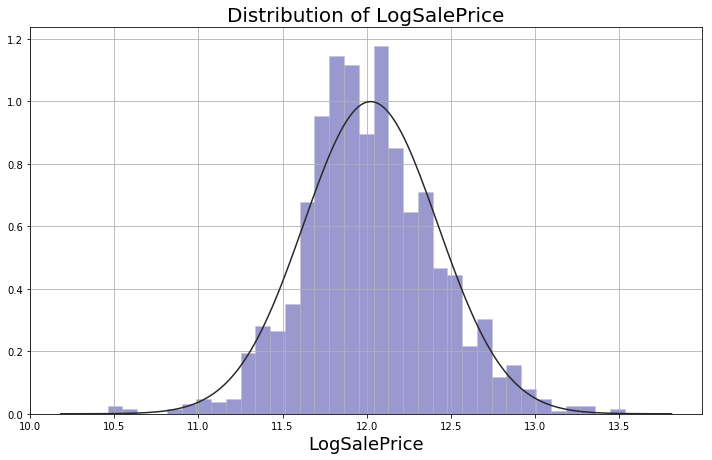

In [10]:
fig, ax = plt.subplots(figsize = (10.0, 6.5))
ax = sns.distplot(train_df.LogSalePrice, color = "darkblue", fit = norm, kde = False, hist_kws = {"edgecolor": "silver"})
ax.set_title("Distribution of LogSalePrice", fontsize = 20)
ax.set_xlabel("LogSalePrice", fontsize = 18)
ax.margins(0.05)
ax.axis("tight")
ax.grid(True)
fig.tight_layout()

plt.show()

In [11]:
corr = num_train_df.corr()

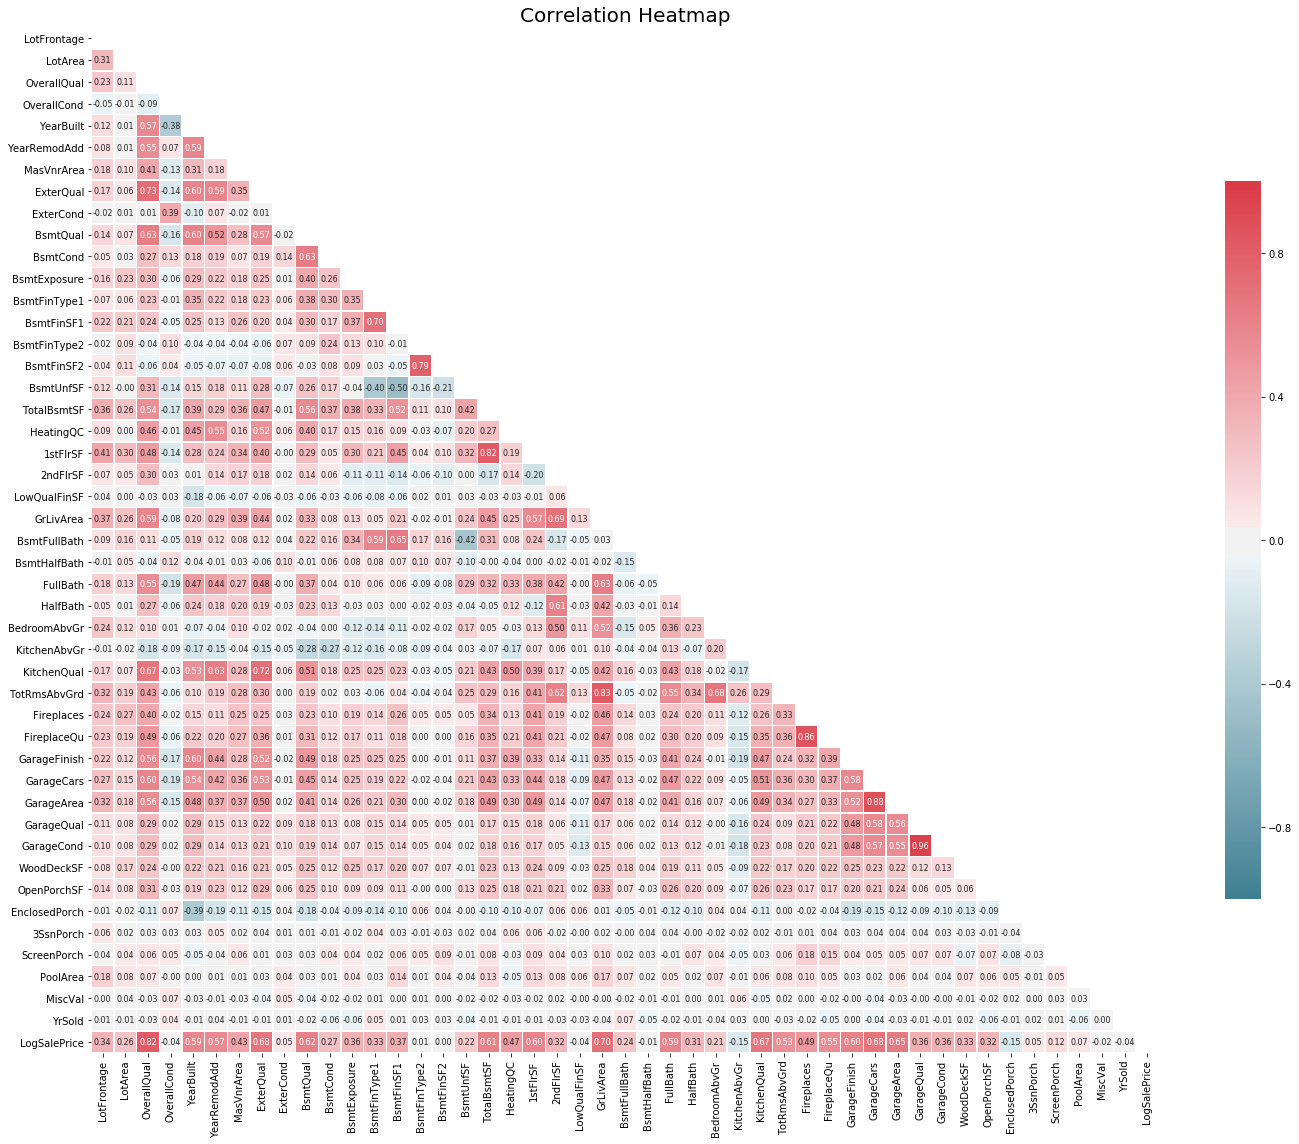

In [12]:
#generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap = True)

fig, ax = plt.subplots(figsize = (20, 16))
ax = sns.heatmap(corr, mask = mask, cmap = cmap, fmt = ".2f", vmin = -1, vmax = 1.0, center = 0, square = True, linewidths = .5, cbar_kws = {"shrink": .7}, annot = True, annot_kws = {"size": 8})
ax.set_title("Correlation Heatmap", fontsize = 20)
ax.margins(0.05)
ax.axis("tight")
ax.grid(False)
fig.tight_layout()

plt.show()

In [13]:
y = num_train_df.LogSalePrice.values
x = num_train_df.drop("LogSalePrice", axis = 1).values

In [14]:
x_train, x_test, y_train, y_test = utils.split_train_test(x, y, prop_train = 80.0)

In [15]:
opt_lm   = None
min_rmse = np.inf

alpha_list = np.linspace(0, 10, num = 1000, dtype = float, endpoint = True)

for alpha in alpha_list:
    model = sbbml.LinearRegression(alpha, iterations = 10000, normalize = True)
    model.fit(x_train, y_train)

    y_prime = model.predict(x_test)
    rmse    = utils.root_mean_squared_error(y_prime, y_test)

    if rmse < min_rmse:
        print(f"rmse: {rmse: <20} \t alpha: {alpha}")
        min_rmse = rmse
        opt_lm   = model

rmse: 20.642329519542763   	 alpha: 0.0
rmse: 0.16746648268105588  	 alpha: 0.01001001001001001


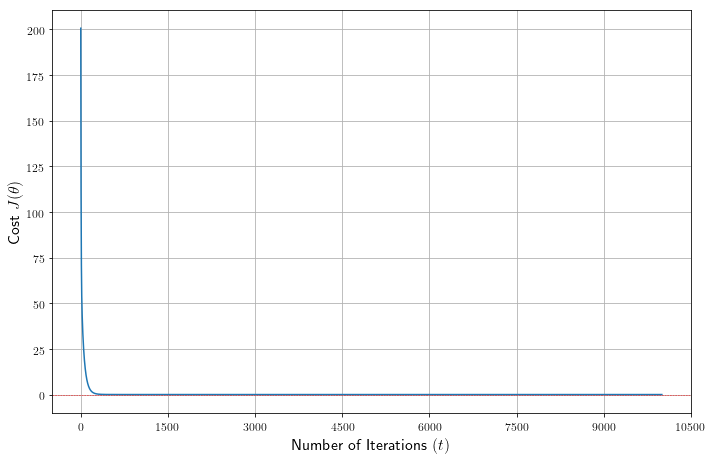

In [16]:
utils.plot_cost_function(cost = opt_lm.cost, width = 10.0, height = 6.5)

In [17]:
test_df    = pd.read_csv("data/house-prices/test.csv", na_values = "", sep = ",")
test_df_id = test_df.Id.values
test_df    = test_df.drop("Id", axis = 1)
test_df    = clean_df(test_df)
utils.missing_var_pct(test_df)

MasVnrType     1.1000
MasVnrArea     1.0300
MSZoning       0.2700
Utilities      0.1400
BsmtFullBath   0.1400
BsmtHalfBath   0.1400
Functional     0.1400
TotalBsmtSF    0.0700
GarageCars     0.0700
BsmtFinSF2     0.0700
BsmtUnfSF      0.0700
SaleType       0.0700
Exterior2nd    0.0700
Exterior1st    0.0700
KitchenQual    0.0700
BsmtFinSF1     0.0700
GarageArea     0.0700
dtype: float64


In [18]:
num_test_df, cat_test_df = utils.split_numerical_categorical(test_df)
num_test_df.fillna(0, inplace = True)

In [19]:
num_test_x = num_test_df.values
y_prime    = opt_lm.predict(num_test_x)
y_prime    = np.exp(y_prime).flatten()

with open("data/house-prices/lr-submission.csv", mode = "w") as f:
    f.write("Id,SalePrice\n")
    for i in range(y_prime.shape[0]):
        f.write(f"{test_df_id[i]},{y_prime[i]}\n")

In [20]:
opt_pc2lr  = None
opt_n_comp = None
min_rmse   = np.inf

ncomp_list = np.linspace(0, 10, num = 100, dtype = int, endpoint = True)
alpha_list = np.linspace(0, 10, num = 1000, dtype = float, endpoint = True)

for n_comp in ncomp_list:
    pca = sbbml.PCA(n_comp)
    pca.fit(x)
    x_reduced = pca.transform(x)
    x_train, x_test, y_train, y_test = utils.split_train_test(x_reduced, y, prop_train = 80.0, seed = 0)

    for alpha in alpha_list:
        model = sbbml.LinearRegression(alpha, iterations = 10000, normalize = True)
        model.fit(x_train, y_train)
        y_prime = model.predict(x_test)
        rmse    = utils.root_mean_squared_error(y_prime, y_test)

        if rmse < min_rmse:
            print(f"rmse: {rmse: <20} \t alpha: {alpha: <20} \t n_comp: {n_comp}")
            min_rmse   = rmse
            opt_pc2lr  = model
            opt_n_comp = n_comp
            opt_pca    = pca

rmse: 10.981999205589085   	 alpha: 0.0                  	 n_comp: 0
rmse: 0.3789933122188987   	 alpha: 0.01001001001001001  	 n_comp: 0
rmse: 0.13319725875244237  	 alpha: 0.01001001001001001  	 n_comp: 1
rmse: 0.13129363856183404  	 alpha: 0.01001001001001001  	 n_comp: 3
rmse: 0.13059960362668452  	 alpha: 0.01001001001001001  	 n_comp: 5
rmse: 0.1305996029340741   	 alpha: 1.911911911911912    	 n_comp: 5
rmse: 0.1302978101843124   	 alpha: 0.01001001001001001  	 n_comp: 6
rmse: 0.13029780935800508  	 alpha: 1.901901901901902    	 n_comp: 6
rmse: 0.1296376245356111   	 alpha: 0.01001001001001001  	 n_comp: 7
rmse: 0.1287406666738656   	 alpha: 0.01001001001001001  	 n_comp: 8
rmse: 0.12874066552759256  	 alpha: 1.901901901901902    	 n_comp: 8


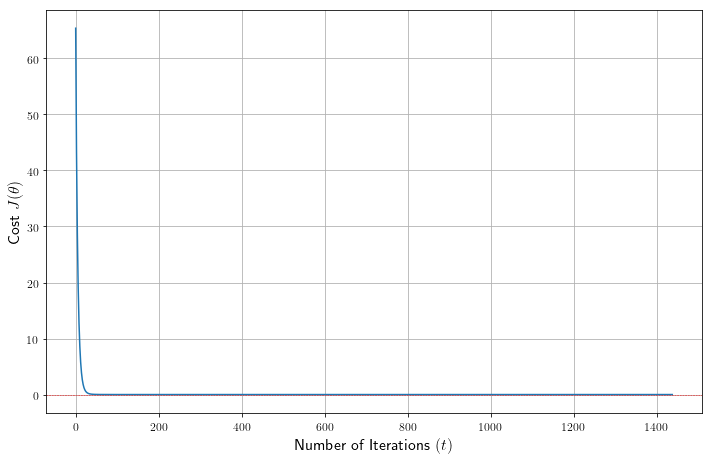

In [21]:
utils.plot_cost_function(cost = opt_pc2lr.cost, width = 10.0, height = 6.5)

In [22]:
num_test_x_reduced = opt_pca.transform(num_test_x)
y_prime = opt_pc2lr.predict(num_test_x_reduced)
y_prime = np.exp(y_prime).flatten()

with open("data/house-prices/pc2lr-submission.csv", mode = "w") as f:
    f.write("Id,SalePrice\n")
    for i in range(y_prime.shape[0]):
        f.write(f"{test_df_id[i]},{y_prime[i]}\n")